In [1]:
!pip install tensorflow
!pip show tensorflow


Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [2]:
!pip install --ignore-installed --upgrade

ERROR: You must give at least one requirement to install (see "pip help install")


In [3]:
!pip install keras



In [4]:
!pip show keras

Name: keras
Version: 2.12.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow


In [5]:
!pip install seaborn


In [8]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
import tensorflow
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


# mounting google drive.
from google.colab import drive
drive.mount('/content/gdrive')

#importing drive path.

import os
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG



Mounted at /content/gdrive
/content/gdrive/MyDrive/pp-217385a (1).jpg
/content/gdrive/MyDrive/pp-217385a.jpg
/content/gdrive/MyDrive/Vaccine Certificate.pdf
/content/gdrive/MyDrive/Screenshot_2022-01-10-16-33-09-02_d924654ed6aefe21bddc16810be74f79 (1).jpg
/content/gdrive/MyDrive/Screenshot_2022-01-10-16-33-14-56_d924654ed6aefe21bddc16810be74f79 (1).jpg
/content/gdrive/MyDrive/Screenshot_2022-01-10-18-17-03-14_008959c34549ce671eb1dd94cfad7b1a.jpg
/content/gdrive/MyDrive/Screenshot_2022-01-10-18-17-10-17_008959c34549ce671eb1dd94cfad7b1a.jpg
/content/gdrive/MyDrive/Screenshot_2022-01-10-16-33-09-02_d924654ed6aefe21bddc16810be74f79.jpg
/content/gdrive/MyDrive/Screenshot_2022-01-10-16-33-14-56_d924654ed6aefe21bddc16810be74f79.jpg
/content/gdrive/MyDrive/IMG-20220120-WA0058.jpg
/content/gdrive/MyDrive/IMG-20220120-WA0059.jpg
/content/gdrive/MyDrive/IMG-20220120-WA0057.jpg
/content/gdrive/MyDrive/IMG-20220120-WA0056.jpg
/content/gdrive/MyDrive/IMG-20220120-WA0055.jpg
/content/gdrive/MyDrive/S

In [12]:
%matplotlib inline
from zipfile import ZipFile
filename = '/content/gdrive/MyDrive/breakhis Dataset/BreaKHis 400X'

import numpy as np

100%|██████████| 369/369 [00:14<00:00, 25.87it/s]


74836368/74836368 [==============================] - 5s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610
No

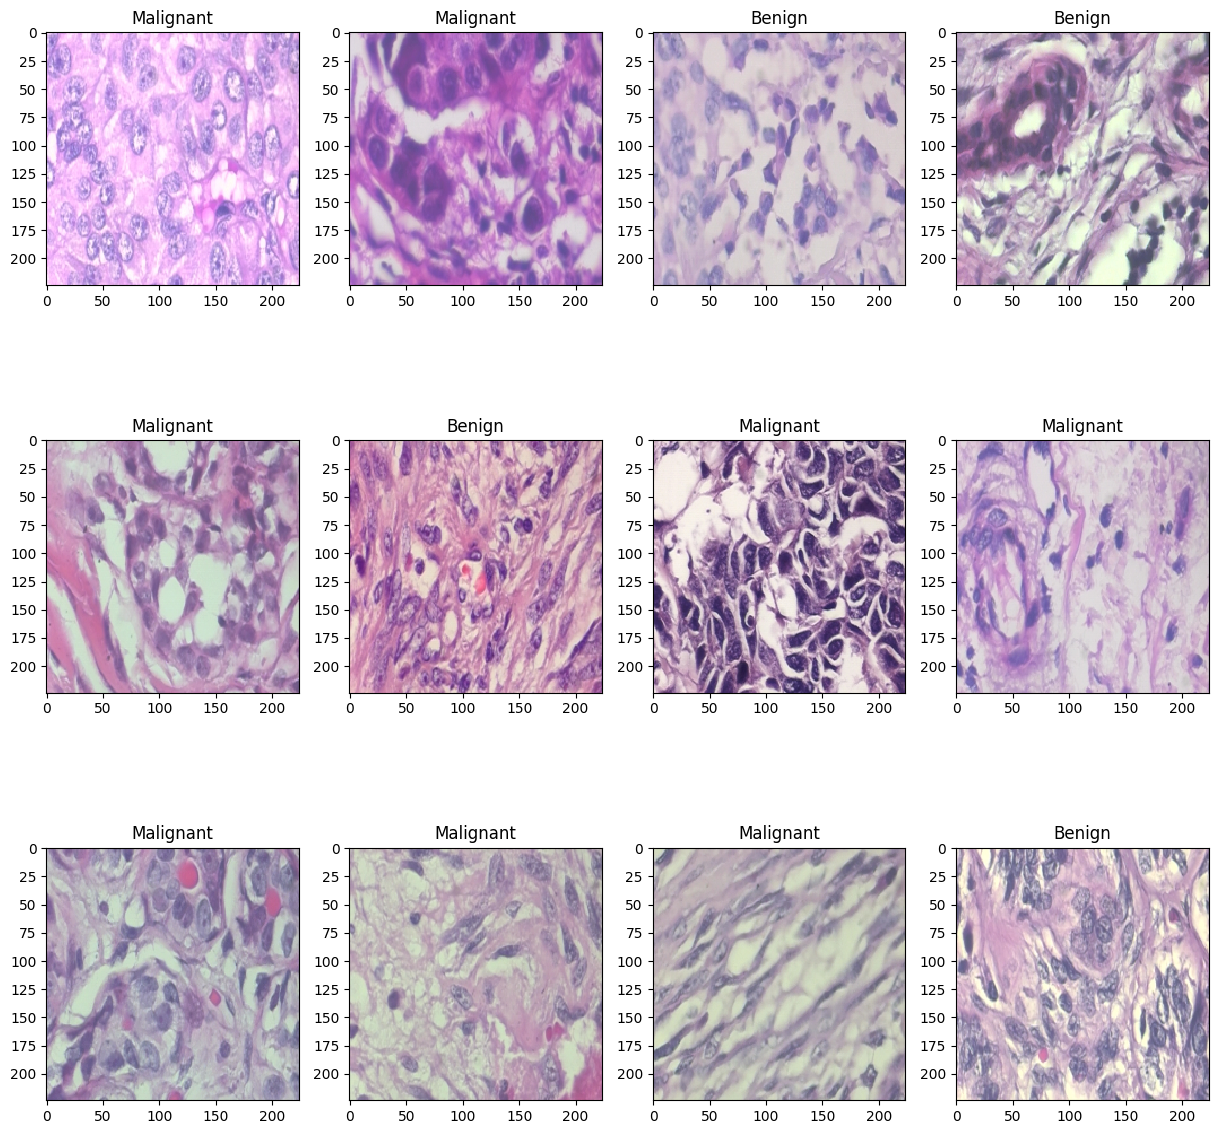

In [16]:
benign_train = np.array(Dataset_loader('/content/gdrive/MyDrive/BreaKHis 400X/train/benign',224))
malign_train = np.array(Dataset_loader('/content/gdrive/MyDrive/BreaKHis 400X/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/gdrive/MyDrive/BreaKHis 400X/test/benign',224))
malign_test = np.array(Dataset_loader('/content/gdrive/MyDrive/BreaKHis 400X/test/malignant',224))
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
#plt.show()
BATCH_SIZE = 16
# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))


    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )

    return model
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)





model = build_model(resnet ,lr = 1e-4)
model.summary()

In [23]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint]
)
model.load_weights("weights.best.hdf5")

Y_val_pred = model.predict(x_val)
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

<ipython-input-23-f3ba380b6dcf>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
58/57 [==============================] - ETA: 0s - loss: 0.5633 - accuracy: 0.7745
Epoch 1: val_accuracy improved from -inf to 0.80435, saving model to /content/gdrive/MyDrive/breakhis Dataset/BreaKHis 400X


57/57 [==============================] - 301s 3s/step - loss: 0.5633 - accuracy: 0.7745 - val_loss: 146.6138 - val_accuracy: 0.8043
Epoch 2/20
58/57 [==============================] - ETA: 0s - loss: 0.4364 - accuracy: 0.8344
Epoch 2: val_accuracy did not improve from 0.80435
57/57 [==============================] - 20s 349ms/step - loss: 0.4364 - accuracy: 0.8344 - val_loss: 36.5586 - val_accuracy: 0.7826
Epoch 3/20
58/57 [==============================] - ETA: 0s - loss: 0.4656 - accuracy: 0.8007
Epoch 3: val_accuracy did not improve from 0.80435
57/57 [==============================] - 21s 362ms/step - loss: 0.4656 - accuracy: 0.8007 - val_loss: 1.3641 - val_accuracy: 0.6957
Epoch 4/20
58/57 [==============================] - ETA: 0s - loss: 0.4775 - accuracy: 0.8083
Epoch 4: val_accuracy improved from 0.80435 to 0.84783, saving model to /content/gdrive/MyDrive/breakhis Dataset/BreaKHis 400X


57/57 [==============================] - 130s 2s/step - loss: 0.4775 - accuracy: 0.8083 - val_loss: 0.4328 - val_accuracy: 0.8478
Epoch 5/20
58/57 [==============================] - ETA: 0s - loss: 0.4203 - accuracy: 0.8268
Epoch 5: val_accuracy did not improve from 0.84783
57/57 [==============================] - 21s 364ms/step - loss: 0.4203 - accuracy: 0.8268 - val_loss: 1.4749 - val_accuracy: 0.4913
Epoch 6/20
58/57 [==============================] - ETA: 0s - loss: 0.4073 - accuracy: 0.8355
Epoch 6: val_accuracy did not improve from 0.84783
57/57 [==============================] - 20s 345ms/step - loss: 0.4073 - accuracy: 0.8355 - val_loss: 1.3405 - val_accuracy: 0.7130
Epoch 7/20
58/57 [==============================] - ETA: 0s - loss: 0.4123 - accuracy: 0.8399
Epoch 7: val_accuracy did not improve from 0.84783
57/57 [==============================] - 22s 381ms/step - loss: 0.4123 - accuracy: 0.8399 - val_loss: 17.6069 - val_accuracy: 0.8217
Epoch 8/20
58/57 [====================

57/57 [==============================] - 135s 2s/step - loss: 0.3970 - accuracy: 0.8617 - val_loss: 0.3721 - val_accuracy: 0.8609
Epoch 9/20
58/57 [==============================] - ETA: 0s - loss: 0.3581 - accuracy: 0.8551
Epoch 9: val_accuracy did not improve from 0.86087
57/57 [==============================] - 22s 373ms/step - loss: 0.3581 - accuracy: 0.8551 - val_loss: 2.5619 - val_accuracy: 0.4217
Epoch 10/20
58/57 [==============================] - ETA: 0s - loss: 0.4043 - accuracy: 0.8453
Epoch 10: val_accuracy did not improve from 0.86087
57/57 [==============================] - 20s 348ms/step - loss: 0.4043 - accuracy: 0.8453 - val_loss: 0.4430 - val_accuracy: 0.7870
Epoch 11/20
58/57 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.8410
Epoch 11: val_accuracy did not improve from 0.86087
57/57 [==============================] - 21s 359ms/step - loss: 0.3603 - accuracy: 0.8410 - val_loss: 1.2288 - val_accuracy: 0.5652
Epoch 12/20
58/57 [================

57/57 [==============================] - 132s 2s/step - loss: 0.3036 - accuracy: 0.8824 - val_loss: 0.2848 - val_accuracy: 0.8870
Epoch 17/20
58/57 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.8660
Epoch 17: val_accuracy did not improve from 0.88696
57/57 [==============================] - 21s 365ms/step - loss: 0.3153 - accuracy: 0.8660 - val_loss: 0.8989 - val_accuracy: 0.7522
Epoch 18/20
58/57 [==============================] - ETA: 0s - loss: 0.3059 - accuracy: 0.8671
Epoch 18: val_accuracy did not improve from 0.88696
57/57 [==============================] - 20s 342ms/step - loss: 0.3059 - accuracy: 0.8671 - val_loss: 0.9697 - val_accuracy: 0.6304
Epoch 19/20
58/57 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.8813
Epoch 19: val_accuracy did not improve from 0.88696
57/57 [==============================] - 21s 359ms/step - loss: 0.3038 - accuracy: 0.8813 - val_loss: 2.0414 - val_accuracy: 0.5043
Epoch 20/20
58/57 [==============

FileNotFoundError: ignored

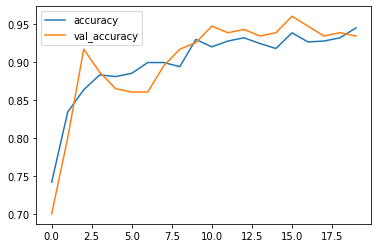

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

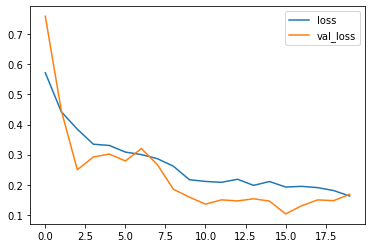

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()


In [ ]:
model.load_weights("weights.best.hdf5")

Y_val_pred = model.predict(x_val)
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9608695652173913

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys
100%|██████████| 10/10 [22:53<00:00, 137.38s/it]


Confusion matrix, without normalization
[[161  15]
 [  8 361]]


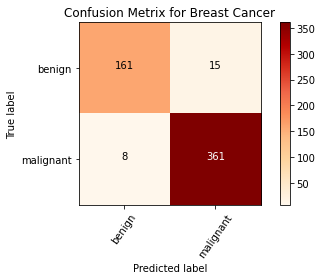

In [ ]:
Y_pred = model.predict(X_test)
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)

    predictions.append(preds)
    gc.collect()

Y_pred_tta = np.mean(predictions, axis=0)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap='OrRd')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')


Confusion matrix, without normalization
[[161  15]
 [  7 362]]


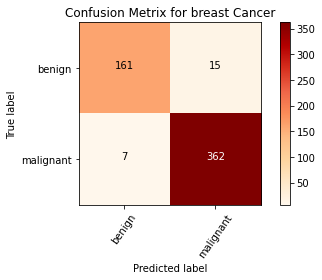

In [ ]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for breast Cancer')

In [ ]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.96      0.91      0.94       176\n           1       0.96      0.98      0.97       369\n\n    accuracy                           0.96       545\n   macro avg       0.96      0.95      0.95       545\nweighted avg       0.96      0.96      0.96       545\n'

Accuracy = 96.08%

---
Precision = 0.91

---
Recall = 0.94

---
F1-score = 0.97









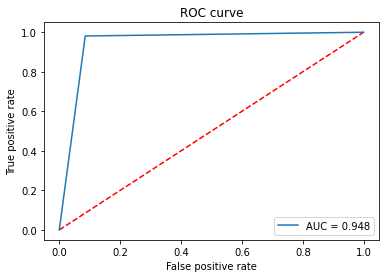

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

ROC-AUC = 0.948

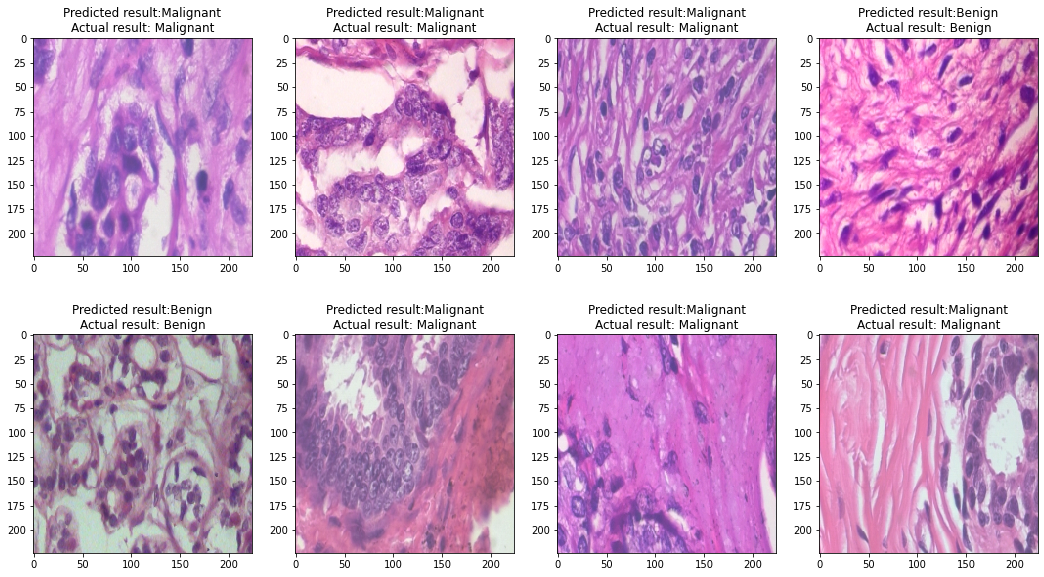

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 random images
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()